In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
# Get data
df = pd.read_csv("../data/cleaned_data.csv")
df.head(5)

,date,location_key,new_persons_vaccinated,cumulative_persons_vaccinated,new_confirmed,mobility_workplaces
0,2022-05-09,US_VA,930.0,7326007.0,0.0,-13.0
1,2021-11-16,US_IA,11191.0,1934013.0,0.0,-11.0
2,2022-02-03,US_GA,0.0,6766353.0,485.0,23.0
3,2021-10-15,US_KY,2794.0,2767917.0,0.0,-21.0
4,2021-04-29,US_MN,20930.0,2621229.0,205.0,-14.0


In [6]:
X = df[['new_persons_vaccinated', 'cumulative_persons_vaccinated', 'mobility_workplaces']]
y = df['new_confirmed']

model = BayesianRidge()
model.fit(X, y)

,max_iter,300
,tol,0.001
,alpha_1,1e-06
,alpha_2,1e-06
,lambda_1,1e-06
,lambda_2,1e-06
,alpha_init,None
,lambda_init,None
,compute_score,False
,fit_intercept,True
,copy_X,True


In [7]:
# Coefficients for each feature in the order of X columns
print("Coefficients:", model.coef_)

# Intercept term
print("Intercept:", model.intercept_)

Coefficients: [-6.47411227e-05  1.15050359e-05 -5.55077174e-06]
Intercept: 10.178419526062541


In [10]:
# Evaluate model 
y_pred = model.predict(X)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

n = X.shape[0]  # number of samples
p = X.shape[1]  # number of predictors

adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print("Adjusted R²:", adjusted_r2)

Mean Squared Error: 1335089.2112302792
R^2 Score: 0.003749731339316109
Adjusted R²: 0.003675005096542394


In [15]:
df.head(1)

,date,location_key,new_persons_vaccinated,cumulative_persons_vaccinated,new_confirmed,mobility_workplaces
0,2022-05-09,US_VA,930.0,7326007.0,0.0,-13.0


[43,
 88,
 130,
 174,
 218,
 283,
 323,
 366,
 398,
 448,
 495,
 555,
 615,
 669,
 725,
 775,
 807,
 850,
 881,
 924,
 973,
 1029,
 1082,
 1115,
 1170,
 1215,
 1273,
 1331,
 1384,
 1443,
 1494,
 1548,
 1610,
 1664,
 1722,
 1790,
 1844,
 1899,
 1951,
 1982,
 2028,
 2086,
 2117,
 2173,
 2227,
 2262,
 2322,
 2365,
 2405,
 2466,
 2509,
 2555,
 2604,
 2635,
 2694,
 2753,
 2803,
 2853,
 2903,
 2952,
 3012,
 3057,
 3092,
 3156,
 3217,
 3264,
 3328,
 3387,
 3440,
 3488,
 3526,
 3587,
 3645,
 3692,
 3735,
 3785,
 3832,
 3885,
 3933,
 3982,
 4029,
 4077,
 4127,
 4180,
 4239,
 4291,
 4354,
 4412,
 4432,
 4469,
 4516,
 4561,
 4615,
 4647,
 4703,
 4750,
 4786,
 4845,
 4890,
 4940,
 5006,
 5037,
 5093,
 5154,
 5194,
 5242,
 5287,
 5346,
 5406,
 5467,
 5507,
 5563,
 5603,
 5635,
 5680,
 5720,
 5765,
 5826,
 5871,
 5916,
 5971,
 6018,
 6069,
 6106,
 6157,
 6199,
 6238,
 6299,
 6354,
 6415,
 6460,
 6510,
 6564,
 6604,
 6655,
 6706,
 6759,
 6795,
 6853,
 6913,
 6916,
 6967,
 7025,
 7078,
 7131,
 7194,
 

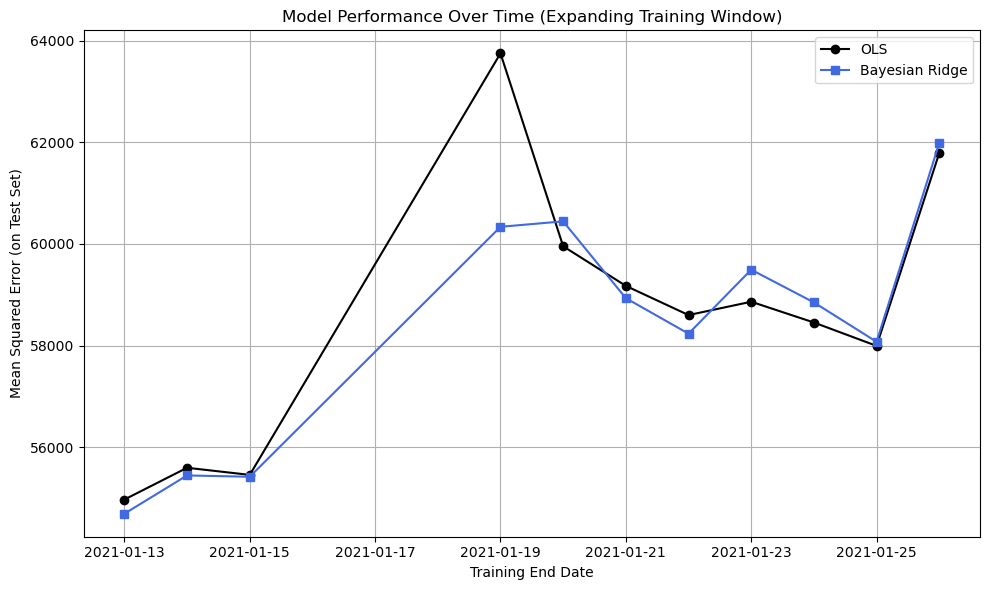

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.metrics import mean_squared_error

# Sort by date
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date').reset_index(drop=True)

# Define features and target
X = df[['new_persons_vaccinated', 'cumulative_persons_vaccinated', 'mobility_workplaces']]
y = df['new_confirmed']

# Use earlier data for training, later for testing (time-ordered)
split_date = df['date'].quantile(0.7)  # first 70% for training
train_df = df[df['date'] <= split_date]
test_df = df[df['date'] > split_date]

X_test = test_df[['new_persons_vaccinated', 'cumulative_persons_vaccinated', 'mobility_workplaces']]
y_test = test_df['new_confirmed']

# Get sorted unique dates in the training set
unique_dates = train_df['date'].sort_values().unique()

results = []

# Iterate through each unique date (incrementally larger training sets)
for d in unique_dates:
    subset = train_df[train_df['date'] <= d]
    X_sub = subset[['new_persons_vaccinated', 'cumulative_persons_vaccinated', 'mobility_workplaces']]
    y_sub = subset['new_confirmed']
    
    # Skip small sample sizes (optional)
    if len(X_sub) < 30:
        continue

    # Fit models
    ols = LinearRegression().fit(X_sub, y_sub)
    bayes = BayesianRidge().fit(X_sub, y_sub)

    # Evaluate on test set
    ols_mse = mean_squared_error(y_test, ols.predict(X_test))
    bayes_mse = mean_squared_error(y_test, bayes.predict(X_test))

    results.append({
        'date': d,
        'OLS': ols_mse,
        'Bayes': bayes_mse,
        'n_samples': len(X_sub)
    })

# Convert results to DataFrame
mle = pd.DataFrame(results)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(mle['date'], mle['OLS'], label='OLS', marker='o', color = 'black')
plt.plot(mle['date'], mle['Bayes'], label='Bayesian Ridge', marker='s', color = 'royalblue')
plt.xlabel('Training End Date')
plt.ylabel('Mean Squared Error (on Test Set)')
plt.title('Model Performance Over Time (Expanding Training Window)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
